## V_MRDH model: OD demand for different modalities

In [2]:
import pandas as pd
import geopandas as gpd
import shapely
import fiona

#### OD matrices

In [3]:
od = {}
# Load the OD demand data: MCdashboard_VMRDH_3.0_uitlever_18-10-2023.xlsx.
od["Totaal"] = pd.read_excel('MCdashboard_VMRDH_3.0_uitlever_18-10-2023.xlsx', sheet_name='Totaal persoonsverplaatsingen', index_col=0, usecols='B:BO', nrows=65)

for modality in ["Auto", "Fiets", "OV"]:
    od[modality] = pd.read_excel('MCdashboard_VMRDH_3.0_uitlever_18-10-2023.xlsx', sheet_name=modality, index_col=0, usecols='B:BO', nrows=65)

In [4]:
od["Fiets"].iloc[3].head()

Rotterdam: Centrum             11888
Rotterdam: Delfshaven           1806
Rotterdam: Noord                8595
Rotterdam: Kralingen           60203
Rotterdam: IJsselmonde (bi)      234
Name: Rotterdam: Kralingen, dtype: int64

In [5]:
# Rename the column and row numbers to 1 to 65
for modality, df in od.items():
    df.index = range(1, 66)
    df.columns = range(1, 66)
    
od["Fiets"].head()

1      2      3      4      5     6     7     8     9     10  ...  56  \
1  55281  14088  12042  12501    296  3700   901   869  1307   772  ...   0   
2  14284  88772   6311   1994    133  1078   596  4229   666   287  ...   0   
3  12297   6330  55861   9273     92   813   194  2745  4773   631  ...   0   
4  11888   1806   8595  60203    234  1483   280   437  1936  3899  ...   0   
5    279    134     91    303  29214  5285  1385    30    37    53  ...  56   

    57  58  59  60  61  62  63  64  65  
1   10   3   0   0   0   0   0   0   0  
2    1   0   0   0   0   0   0   0   0  
3    0   0   0   0   0   0   0   0   0  
4   16   0   0   0   0   0   0   0   0  
5  269  51   0   0   0   0   0   0   0  

[5 rows x 65 columns]

#### Geo data

In [6]:
# Check the layers in areas_v2.shp with fiona
with fiona.open('GIS-VMRDH-Areas/areas_v2.shp') as src:
    print(src.schema)

{'properties': {'AREANR': 'int:11', 'NAME': 'str:50', 'CENTROIDNR': 'int:11', 'GEBIEDEN': 'str:50', 'GEMEENTEN': 'str:50', 'WONINGEN_A': 'float:18.8', 'INWONERS_A': 'float:18.8', 'ARBEIDSPL_': 'float:18.8', 'LLP12EO_AR': 'float:18.8', 'LLP0011_AR': 'float:18.8', 'PARKEER_TA': 'float:18.8', 'AUTOSPERHH': 'float:18.8', 'STEDELIJKH': 'float:18.8', 'MATRIXCOMP': 'str:50', '_errors': 'str:254', 'layer': 'str:254', 'path': 'str:254'}, 'geometry': 'Polygon'}


In [7]:
from shapely.geometry import shape, Polygon, MultiPolygon
from shapely.validation import make_valid
from shapely.errors import TopologicalError
from fiona import collection

# Function to clean geometries
def clean_geometries(geom):
    try:
        if not geom.is_valid:
            # Attempt to fix invalid geometries
            geom = make_valid(geom)
        return geom
    except TopologicalError as e:
        print(f"Topological error when cleaning geometry: {e}")
        return None
    except Exception as e:
        print(f"Error cleaning geometry: {e}")
        return None

# Function to validate the number of points in geometries
def is_valid_geometry(geom):
    if geom.geom_type == 'Polygon':
        rings = list(geom.interiors) + [geom.exterior]
        for ring in rings:
            if len(ring.coords) < 4:
                return False
    elif geom.geom_type == 'MultiPolygon':
        for poly in geom.geoms:
            if not is_valid_geometry(poly):
                return False
    return True

In [8]:
# Load the shapefile and clean geometries
def load_clean_shapefile(filepath):
    with collection(filepath, "r") as source:
        schema = source.schema.copy()
        cleaned_geometries = []

        for feature in source:
            try:
                geom = shape(feature['geometry'])
                
                if is_valid_geometry(geom):
                    cleaned_geom = clean_geometries(geom)
                    if cleaned_geom:
                        cleaned_geometries.append({
                            'geometry': cleaned_geom,
                            'properties': feature['properties'],
                        })
                else:
                    print(f"Invalid geometry found: {feature['id']}")
            except ValueError as ve:
                print(f"ValueError: {ve} in feature {feature['id']}")
            except Exception as e:
                print(f"Error processing feature {feature['id']}: {e}")

    # Create a GeoDataFrame with cleaned geometries
    gdf = gpd.GeoDataFrame.from_features(cleaned_geometries, crs=source.crs)
    return gdf

# Load the cleaned shapefile
areas = load_clean_shapefile('GIS-VMRDH-Areas/areas_v2.shp')
# Set the CRS to RD
areas.set_crs(epsg=28992, inplace=True)

ValueError: A linearring requires at least 4 coordinates. in feature 594
ValueError: A linearring requires at least 4 coordinates. in feature 1176
ValueError: A linearring requires at least 4 coordinates. in feature 1217
ValueError: A linearring requires at least 4 coordinates. in feature 2360
ValueError: A linearring requires at least 4 coordinates. in feature 3105
ValueError: A linearring requires at least 4 coordinates. in feature 3199
ValueError: A linearring requires at least 4 coordinates. in feature 3493
ValueError: A linearring requires at least 4 coordinates. in feature 3531
ValueError: A linearring requires at least 4 coordinates. in feature 3550
ValueError: A linearring requires at least 4 coordinates. in feature 3597
ValueError: A linearring requires at least 4 coordinates. in feature 3599
ValueError: A linearring requires at least 4 coordinates. in feature 3615
ValueError: A linearring requires at least 4 coordinates. in feature 3632
ValueError: A linearring requires at le

geometry  AREANR  NAME  \
0     POLYGON ((78619.991 458209.329, 78652 458224.0...      69  None   
1     MULTIPOLYGON (((86316.873 451590.365, 86273.71...    2018  None   
2     POLYGON ((87536.127 451876.295, 87288.354 4520...    2032  None   
3     POLYGON ((92088.81 430493.564, 91811.565 43032...    3857  None   
4     POLYGON ((96024.267 431490.321, 96026.001 4314...    3906  None   
...                                                 ...     ...   ...   
7040  POLYGON ((207679.11 498794.09, 208053.684 4983...    7782  None   
7041  POLYGON ((243110.07 500981.71, 243705.69 50064...    7783  None   
7042  POLYGON ((192526.22 417407.4, 192606.85 417353...    7784  None   
7043  POLYGON ((189820.84 369614, 191505.97 368844.4...    7785  None   
7044  POLYGON ((185612 341904.6, 185629.2 341757.5, ...    7786  None   

      CENTROIDNR                GEBIEDEN           GEMEENTEN  WONINGEN_A  \
0             69        studiegebied VMH         sGravenhage       580.0   
1           2018        studiegebied VMH  Pijnacker_Nootdorp       153.0   
2           2032        studiegebied VMH  Pijnacker_Nootdorp         4.0   
3           3857       studiegebied RVMK       Albrandswaard       432.0   
4           3906       studiegebied RVMK         Barendrecht         0.0   
...          ...                     ...                 ...         ...   
7040        7782  Buitengebied obv COROP                None     69878.0   
7041        7783  Buitengebied obv COROP                None    278748.0   
7042        7784  Buitengebied obv COROP                None    125594.0   
7043        7785  Buitengebied obv COROP                None    107930.0   
7044        7786  Buitengebied obv COROP                None    298545.0   

      INWONERS_A  ARBEIDSPL_  LLP12EO_AR  LLP0011_AR  PARKEER_TA  AUTOSPERHH  \
0         1019.0       180.0         0.0         0.0         4.0        0.76   
1          455.0        12.0         0.0         0.0         0.0        1.09   
2           18.0       510.0         0.0         0.0         0.0        1.80   
3         1437.0        73.0         0.0         0.0         0.0        1.04   
4            0.0         6.0         0.0         0.0         0.0        0.00   
...          ...         ...         ...         ...         ...         ...   
7040    156469.0     66496.0     21520.0     12954.0         0.0        1.07   
7041    630732.0    277548.0     87852.0     51655.0         0.0        1.14   
7042    282480.0    124789.0     20194.0     20498.0         0.0        1.21   
7043    237269.0     97806.0     16302.0     16388.0         0.0        1.26   
7044    596823.0    241073.0     78626.0     37467.0         0.0        1.06   

      STEDELIJKH MATRIXCOMP                 _errors  layer  \
0            5.0       None  Ring self-intersection  fixed   
1            4.0       None       Self-intersection  fixed   
2            4.0       None  Ring self-intersection  fixed   
3            3.0       None  Ring self-intersection  fixed   
4            4.0       None  Ring self-intersection  fixed   
...          ...        ...                     ...    ...   
7040         0.0       None                    None  valid   
7041         0.0       None                    None  valid   
7042         0.0       None                    None  valid   
7043         0.0       None                    None  valid   
7044         0.0       None                    None  valid   

                                                   path  
0     MultiPolygon?crs=EPSG:28992&field=AREANR:long(...  
1     MultiPolygon?crs=EPSG:28992&field=AREANR:long(...  
2     MultiPolygon?crs=EPSG:28992&field=AREANR:long(...  
3     MultiPolygon?crs=EPSG:28992&field=AREANR:long(...  
4     MultiPolygon?crs=EPSG:28992&field=AREANR:long(...  
...                                                 ...  
7040  MultiPolygon?crs=EPSG:28992&field=AREANR:long(...  
7041  MultiPolygon?crs=EPSG:28992&field=AREANR:long(...  
7042  MultiPolygon?crs=EPSG:2

<Axes: >

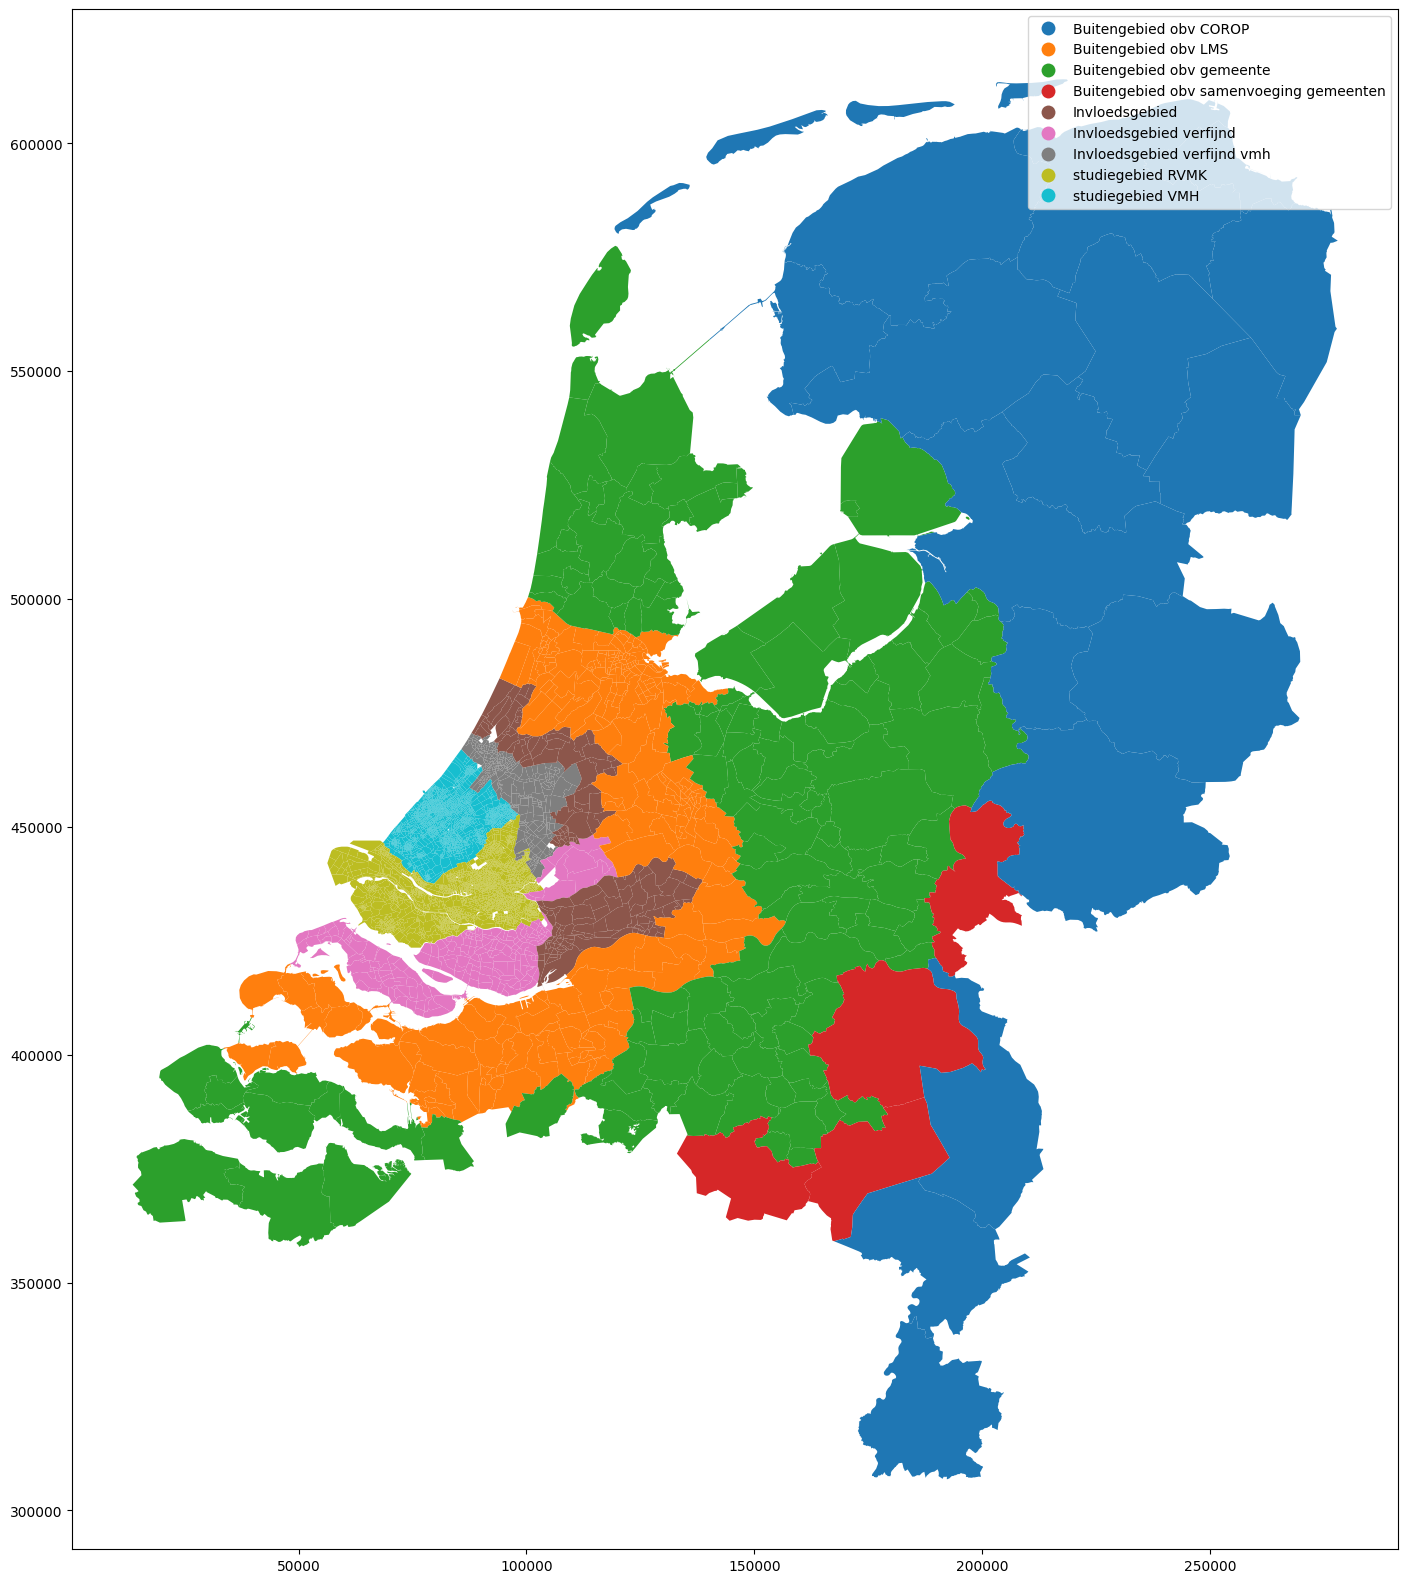

In [9]:
# Plot the areas, colored by GEBIEDEN
areas.plot(column='GEBIEDEN', legend=True, figsize=(20, 20))

In [10]:
len(areas)

7045

In [11]:
# Print unique vlaues for GEBIEDen
areas["GEBIEDEN"].unique()

array(['studiegebied VMH', 'studiegebied RVMK',
       'Invloedsgebied verfijnd vmh', 'Invloedsgebied verfijnd',
       'Invloedsgebied', 'Buitengebied obv LMS',
       'Buitengebied obv gemeente',
       'Buitengebied obv samenvoeging gemeenten',
       'Buitengebied obv COROP'], dtype=object)

### Mapping

In [12]:
# Load 02_Segbestand_V-MRDH_3.0_uitlever_18102023.xlsx
mapping = pd.read_excel('02_Segbestand_V-MRDH_3.0_uitlever_18102023.xlsx', sheet_name='2020', skiprows=30)
mapping.head(100)

zone    65x65 Naam        plaats  65x65 Nummer  1: woningen  2: inwoners  \
0      1  Scheveningen  s-Gravenhage            25            0            0   
1      2  Scheveningen  s-Gravenhage            25            0            0   
2      3   Haagse Hout  s-Gravenhage            26           96          120   
3      4   Haagse Hout  s-Gravenhage            26          124          166   
4      5   Haagse Hout  s-Gravenhage            26          230          292   
..   ...           ...           ...           ...          ...          ...   
95    96   Haagse Hout  s-Gravenhage            26          100          250   
96    97   Haagse Hout  s-Gravenhage            26          108          317   
97    98   Haagse Hout  s-Gravenhage            26          266          593   
98    99   Haagse Hout  s-Gravenhage            26          358          756   
99   100   Haagse Hout  s-Gravenhage            26          351          613   

    3: inwon0034  4: bbv  5: llp12eo  6: detail  ...  \
0              0       0           0          0  ...   
1              0       0           0          0  ...   
2              0      31           0          0  ...   
3              3      43           0          2  ...   
4              8      76           0          1  ...   
..           ...     ...         ...        ...  ...   
95            93      91           0          0  ...   
96           140     115           0          4  ...   
97           250     255           0         73  ...   
98           298     324           0         30  ...   
99           245     259           0          9  ...   

    37: vr_distributiecentrumfunctie  38: vr_kantoor  39: vr_overig  \
0                                  0               0             39   
1                                  0             452            484   
2                                  0               0              4   
3                                  0              15             46   
4                                  0              50             44   
..                               ...             ...            ...   
95                                 0              34              2   
96                                 0              10              0   
97                                 0              68             10   
98                                 0              41             36   
99                                 0              31              4   

    40:vr_terminalfunctie_m2  # auto's  auto's per hh  Unnamed: 46  \
0                          0    0.0000       0.000000       18.000   
1                          0    0.0000       0.000000        0.000   
2                          0   77.8872       0.811325       37.965   
3                          0  100.6026       0.811311       35.650   
4                          0  186.9128       0.812664       61.250   
..                       ...       ...            ...          ...   
95                         0   72.0850       0.720850       27.344   
96                         0   77.9931       0.722158       25.442   
97                         0  215.2786       0.809318       37.809   
98                         0  289.2793       0.808043      105.031   
99                         0  269.2262       0.767026       45.939   

    Unnamed: 47  Unnamed: 48  Unnamed: 49  
0         0.000     3.000000         18.0  
1         0.000     3.000000          0.0  
2         1.662    22.842960        110.7  
3         2.146    16.612302        129.6  
4         3.607    16.980871        235.8  
..          ...          ...          ...  
95        2.019    13.543338         94.5  
96        1.991    12.778503         98.1  
97        4.895     7.724004        237.6  
98        7.141    14.708164        373.5  
99        5.221     8.798889        300.0  

[100 rows x 50 columns]

In [13]:
areas.head()

geometry  AREANR  NAME  \
0  POLYGON ((78619.991 458209.329, 78652 458224.0...      69  None   
1  MULTIPOLYGON (((86316.873 451590.365, 86273.71...    2018  None   
2  POLYGON ((87536.127 451876.295, 87288.354 4520...    2032  None   
3  POLYGON ((92088.81 430493.564, 91811.565 43032...    3857  None   
4  POLYGON ((96024.267 431490.321, 96026.001 4314...    3906  None   

   CENTROIDNR           GEBIEDEN           GEMEENTEN  WONINGEN_A  INWONERS_A  \
0          69   studiegebied VMH         sGravenhage       580.0      1019.0   
1        2018   studiegebied VMH  Pijnacker_Nootdorp       153.0       455.0   
2        2032   studiegebied VMH  Pijnacker_Nootdorp         4.0        18.0   
3        3857  studiegebied RVMK       Albrandswaard       432.0      1437.0   
4        3906  studiegebied RVMK         Barendrecht         0.0         0.0   

   ARBEIDSPL_  LLP12EO_AR  LLP0011_AR  PARKEER_TA  AUTOSPERHH  STEDELIJKH  \
0       180.0         0.0         0.0         4.0        0.76         5.0   
1        12.0         0.0         0.0         0.0        1.09         4.0   
2       510.0         0.0         0.0         0.0        1.80         4.0   
3        73.0         0.0         0.0         0.0        1.04         3.0   
4         6.0         0.0         0.0         0.0        0.00         4.0   

  MATRIXCOMP                 _errors  layer  \
0       None  Ring self-intersection  fixed   
1       None       Self-intersection  fixed   
2       None  Ring self-intersection  fixed   
3       None  Ring self-intersection  fixed   
4       None  Ring self-intersection  fixed   

                                                path  
0  MultiPolygon?crs=EPSG:28992&field=AREANR:long(...  
1  MultiPolygon?crs=EPSG:28992&field=AREANR:long(...  
2  MultiPolygon?crs=EPSG:28992&field=AREANR:long(...  
3  MultiPolygon?crs=EPSG:28992&field=AREANR:long(...  
4  MultiPolygon?crs=EPSG:28992&field=AREANR:long(...

In [14]:
areas_2 = areas.merge(mapping, left_on='AREANR', right_on='zone', how='left')

In [15]:
# 'AREANR', 'NAME', 'CENTROIDNR', 'GEBIEDEN', 'GEMEENTEN',
#        'WONINGEN_A', 'INWONERS_A', 'ARBEIDSPL_', 'LLP12EO_AR', 'LLP0011_AR',
#        'PARKEER_TA', 'AUTOSPERHH', 'STEDELIJKH', 'MATRIXCOMP', '_errors',
#        'layer', 'path', 'zone', '65x65 Naam', 'plaats', '1: woningen',
#        '2: inwoners', '3: inwon0034', '4: bbv', '5: llp12eo', '6: detail',
#        '7: industrie', '8: rest', '9: arbeidspl_totaal', '10: gebiedstype',
#        '11: intrazonaal', '12: vrachtformule', '13: autosperhh',
#        '14: v_os_auto', '15: a_os_auto', '16: v_as_auto', '17: a_as_auto',
#        '18: v_rd_auto', '19: a_rd_auto', '20: va_mz_os', '21: va_mz_as',
#        '22: va_mz_rd', '23: va_zw_os', '24: va_zw_as', '25: va_zw_rd',
#        '26: inwon0011', '27: llp0011', '28: stedelijkheid', '29: hh 0 autos',
#        '30: hh 1 auto', '31: hh 2 autos', '32: hh 3 of meer autos',
#        '33: parkeertarief', '34: parkeerplaatsen', '35: vr_supermarktfunctie',
#        '36: vr_agrarischefunctie', '37: vr_distributiecentrumfunctie',
#        '38: vr_kantoor', '39: vr_overig', '40:vr_terminalfunctie_m2',

In [16]:
agg_dict = {'65x65 Naam': 'first', 'GEBIEDEN': 'first', 'WONINGEN_A': 'sum', 'INWONERS_A': 'sum', 'ARBEIDSPL_': 'sum', 'LLP12EO_AR': 'sum', 'LLP0011_AR': 'sum', 'PARKEER_TA': 'median', 'AUTOSPERHH': 'median', 'STEDELIJKH': 'median',
            'plaats': 'first', '1: woningen': 'sum', '2: inwoners': 'sum', '3: inwon0034': 'sum', '4: bbv': 'sum', '5: llp12eo': 'sum', '6: detail': 'sum', '7: industrie': 'sum', '8: rest': 'sum', '9: arbeidspl_totaal': 'sum',
            '10: gebiedstype': 'first'}

In [26]:
areas_65 = areas_2.dissolve(by='65x65 Nummer', aggfunc=agg_dict)

# Select 'studiegebied RVMK', 'studiegebied VMH' from GEBIEDEN
areas_mrdh = areas_65[areas_65['GEBIEDEN'].isin(['studiegebied RVMK', 'studiegebied VMH'])]

# Save both as pickle
areas_65.to_pickle('areas_65.pkl')
areas_mrdh.to_pickle('areas_mrdh.pkl')

areas_65.head(15)

geometry  \
65x65 Nummer                                                      
1             MULTIPOLYGON (((92202 435273, 92170 435255, 92...   
2             POLYGON ((89429 435269.999, 89384 435277.999, ...   
3             POLYGON ((89677.053 437491.512, 89672.17 43749...   
4             POLYGON ((93801.859 437558.61, 93800.797 43756...   
5             POLYGON ((95498.799 431529.92, 95400.377 43152...   
6             POLYGON ((93827.057 433032.127, 93810.528 4330...   
7             POLYGON ((90129.907 431496.451, 90130.941 4314...   
8             MULTIPOLYGON (((87823.276 438320.147, 87812.50...   
9             POLYGON ((91886.648 439535.681, 91872.905 4395...   
10            MULTIPOLYGON (((96832.094 435634.989, 96833.33...   
11            POLYGON ((98184.989 434027.95, 98183.211 43403...   
12            POLYGON ((67321 443985, 66757 444237.999, 6669...   
13            POLYGON ((83873.722 429383.583, 83820.168 4294...   
14            POLYGON ((75441.039 435611.468, 75401.552 4356...   
15            POLYGON ((86083.748 431738.958, 86083.868 4317...   

                           65x65 Naam           GEBIEDEN  WONINGEN_A  \
65x65 Nummer                                                           
1                   Rotterdam Centrum  studiegebied RVMK     21529.0   
2                          Delfshaven  studiegebied RVMK     39740.0   
3                               Noord  studiegebied RVMK     29516.0   
4                           Kralingen  studiegebied RVMK     30714.0   
5                    IJsselmonde (bi)  studiegebied RVMK     22324.0   
6                           Feyenoord  studiegebied RVMK     37132.0   
7                            Charlois  studiegebied RVMK     34376.0   
8                           Overschie  studiegebied RVMK      8568.0   
9             HillegersbergSchiebroek  studiegebied RVMK     20504.0   
10                    Prins Alexander  studiegebied RVMK     46332.0   
11                  IJsselmonde (bui)  studiegebied RVMK      6631.0   
12                   Hoek van Holland  studiegebied RVMK      4830.0   
13                          Hoogvliet  studiegebied RVMK     16268.0   
14                          Rozenburg  studiegebied RVMK      5720.0   
15                 Eemhaven Waalhaven  studiegebied RVMK      3012.0   

              INWONERS_A  ARBEIDSPL_  LLP12EO_AR  LLP0011_AR  PARKEER_TA  \
65x65 Nummer                                                               
1                36209.0     88158.0     37649.0      2213.0        4.14   
2                77508.0     17468.0      9165.0      6332.0        1.76   
3                52490.0     12453.0     10649.0      2807.0        1.76   
4                53939.0     25025.0     36520.0      4257.0        1.76   
5                45467.0     16658.0      4404.0      3906.0        0.00   
6                76372.0     38347.0     16524.0      6876.0        1.76   
7                67670.0     15969.0      3428.0      5501.0        0.00   
8                18932.0     24564.0       363.0      1833.0        0.00   
9                44608.0     14063.0      4693.0      4919.0        0.00   
10               96003.0     34414.0     10331.0      7802.0        0.00   
11               15416.0      1562.0         0.0      1323.0        0.00   
12               10371.0      2722.0         0.0       684.0        0.00   
13               35177.0      9742.0      2451.0      2579.0        0.00   
14               12482.0      1898.0       150.0       964.0        0.00   
15                6507.0     18458.0      2574.0       353.0        0.00   

              AUTOSPERHH  ...  1: woningen 2: inwoners  3: inwon0034  4: bbv  \
65x65 Nummer              ...                                                  
1                  0.495  ...        21529       36209         18948   16284   
2                  0.460  ...        39740       77508         41160   30429   
3                  0.425  ...        29516       52490         27808   23956 

In [21]:
# Print unique GEBIEDEN
areas_65["GEBIEDEN"].unique()

array(['studiegebied RVMK', 'studiegebied VMH', 'Invloedsgebied',
       'Invloedsgebied verfijnd vmh', 'Invloedsgebied verfijnd',
       'Buitengebied obv LMS', 'Buitengebied obv COROP'], dtype=object)

<Axes: >

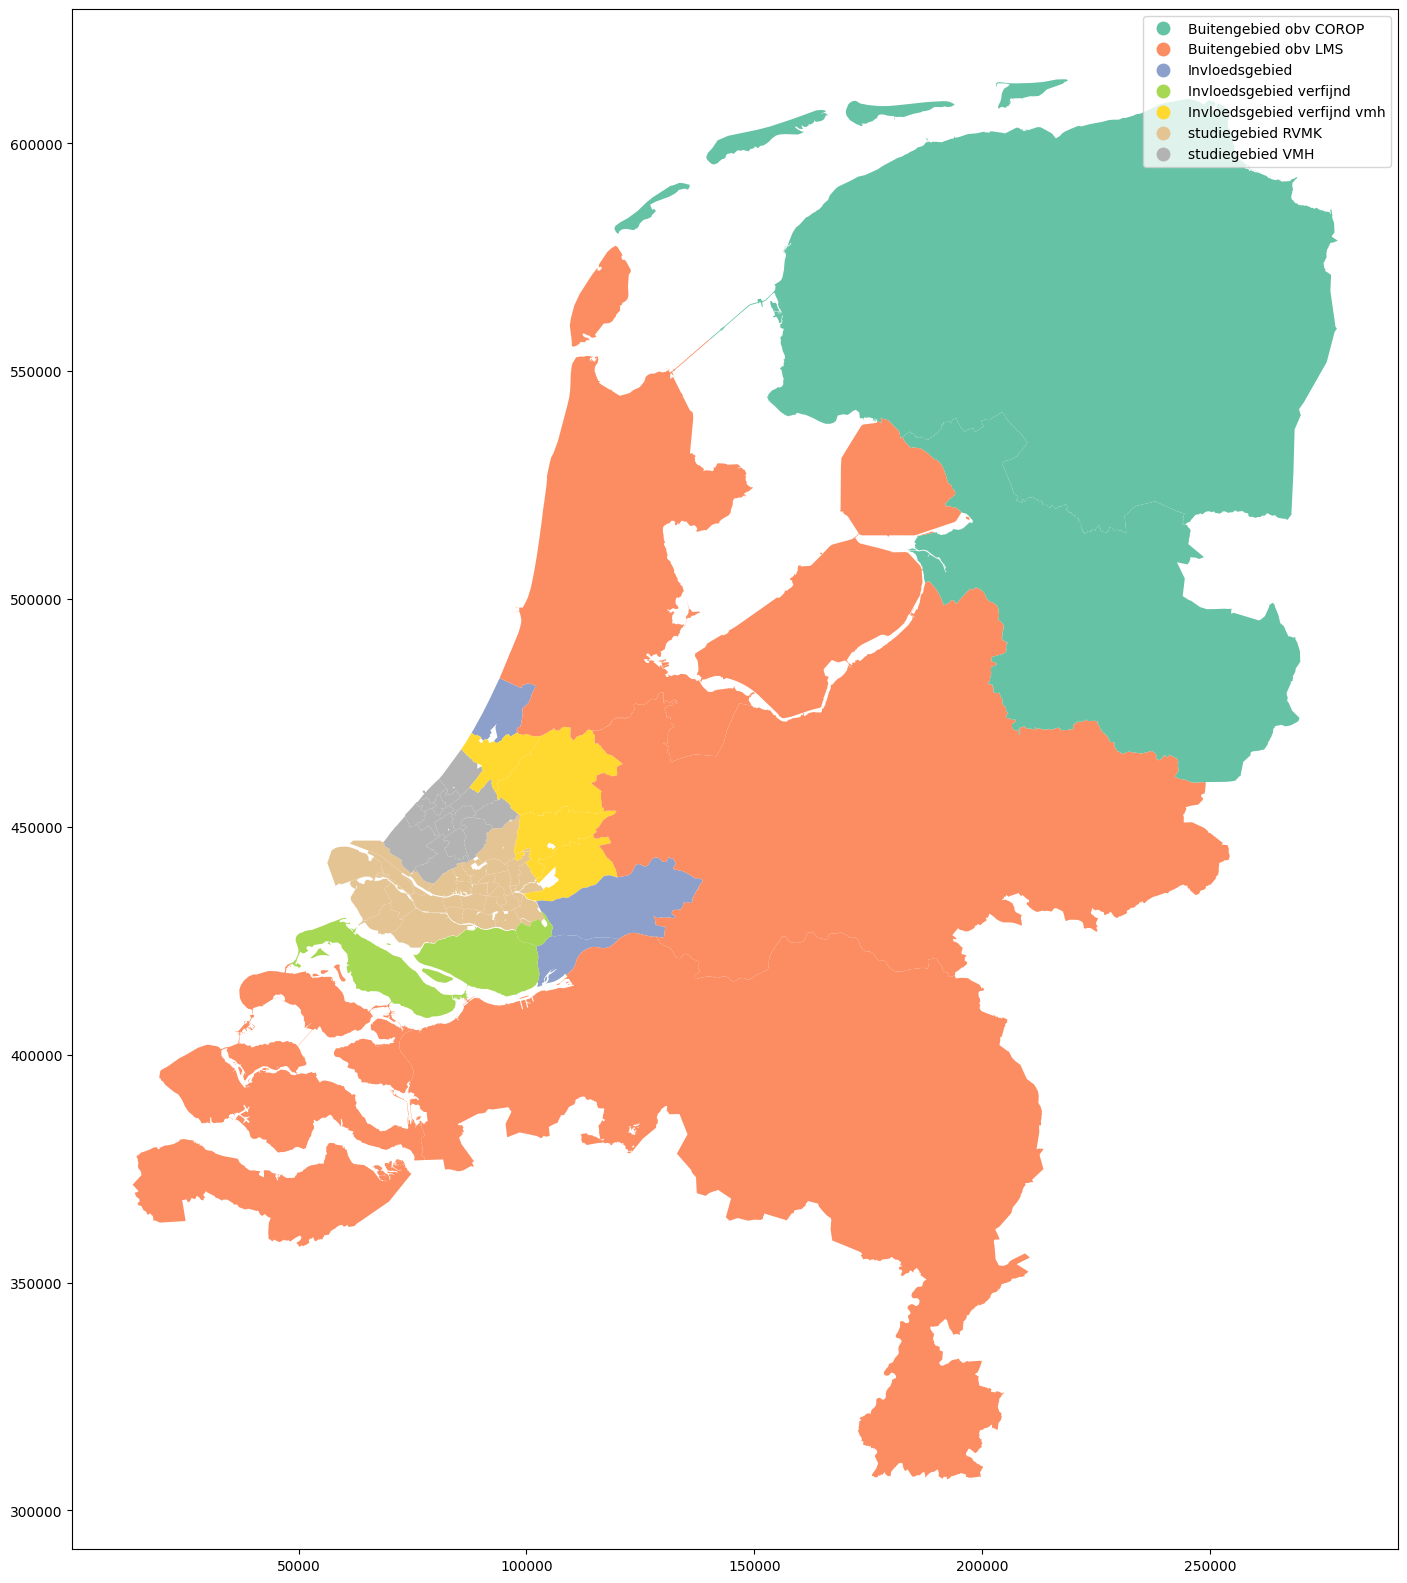

In [25]:
areas_65.plot(column="GEBIEDEN", legend=True, figsize=(20, 20), cmap='Set2')

### Plot OD demand

In [114]:
import matplotlib.pyplot as plt
from shapely.geometry import LineString

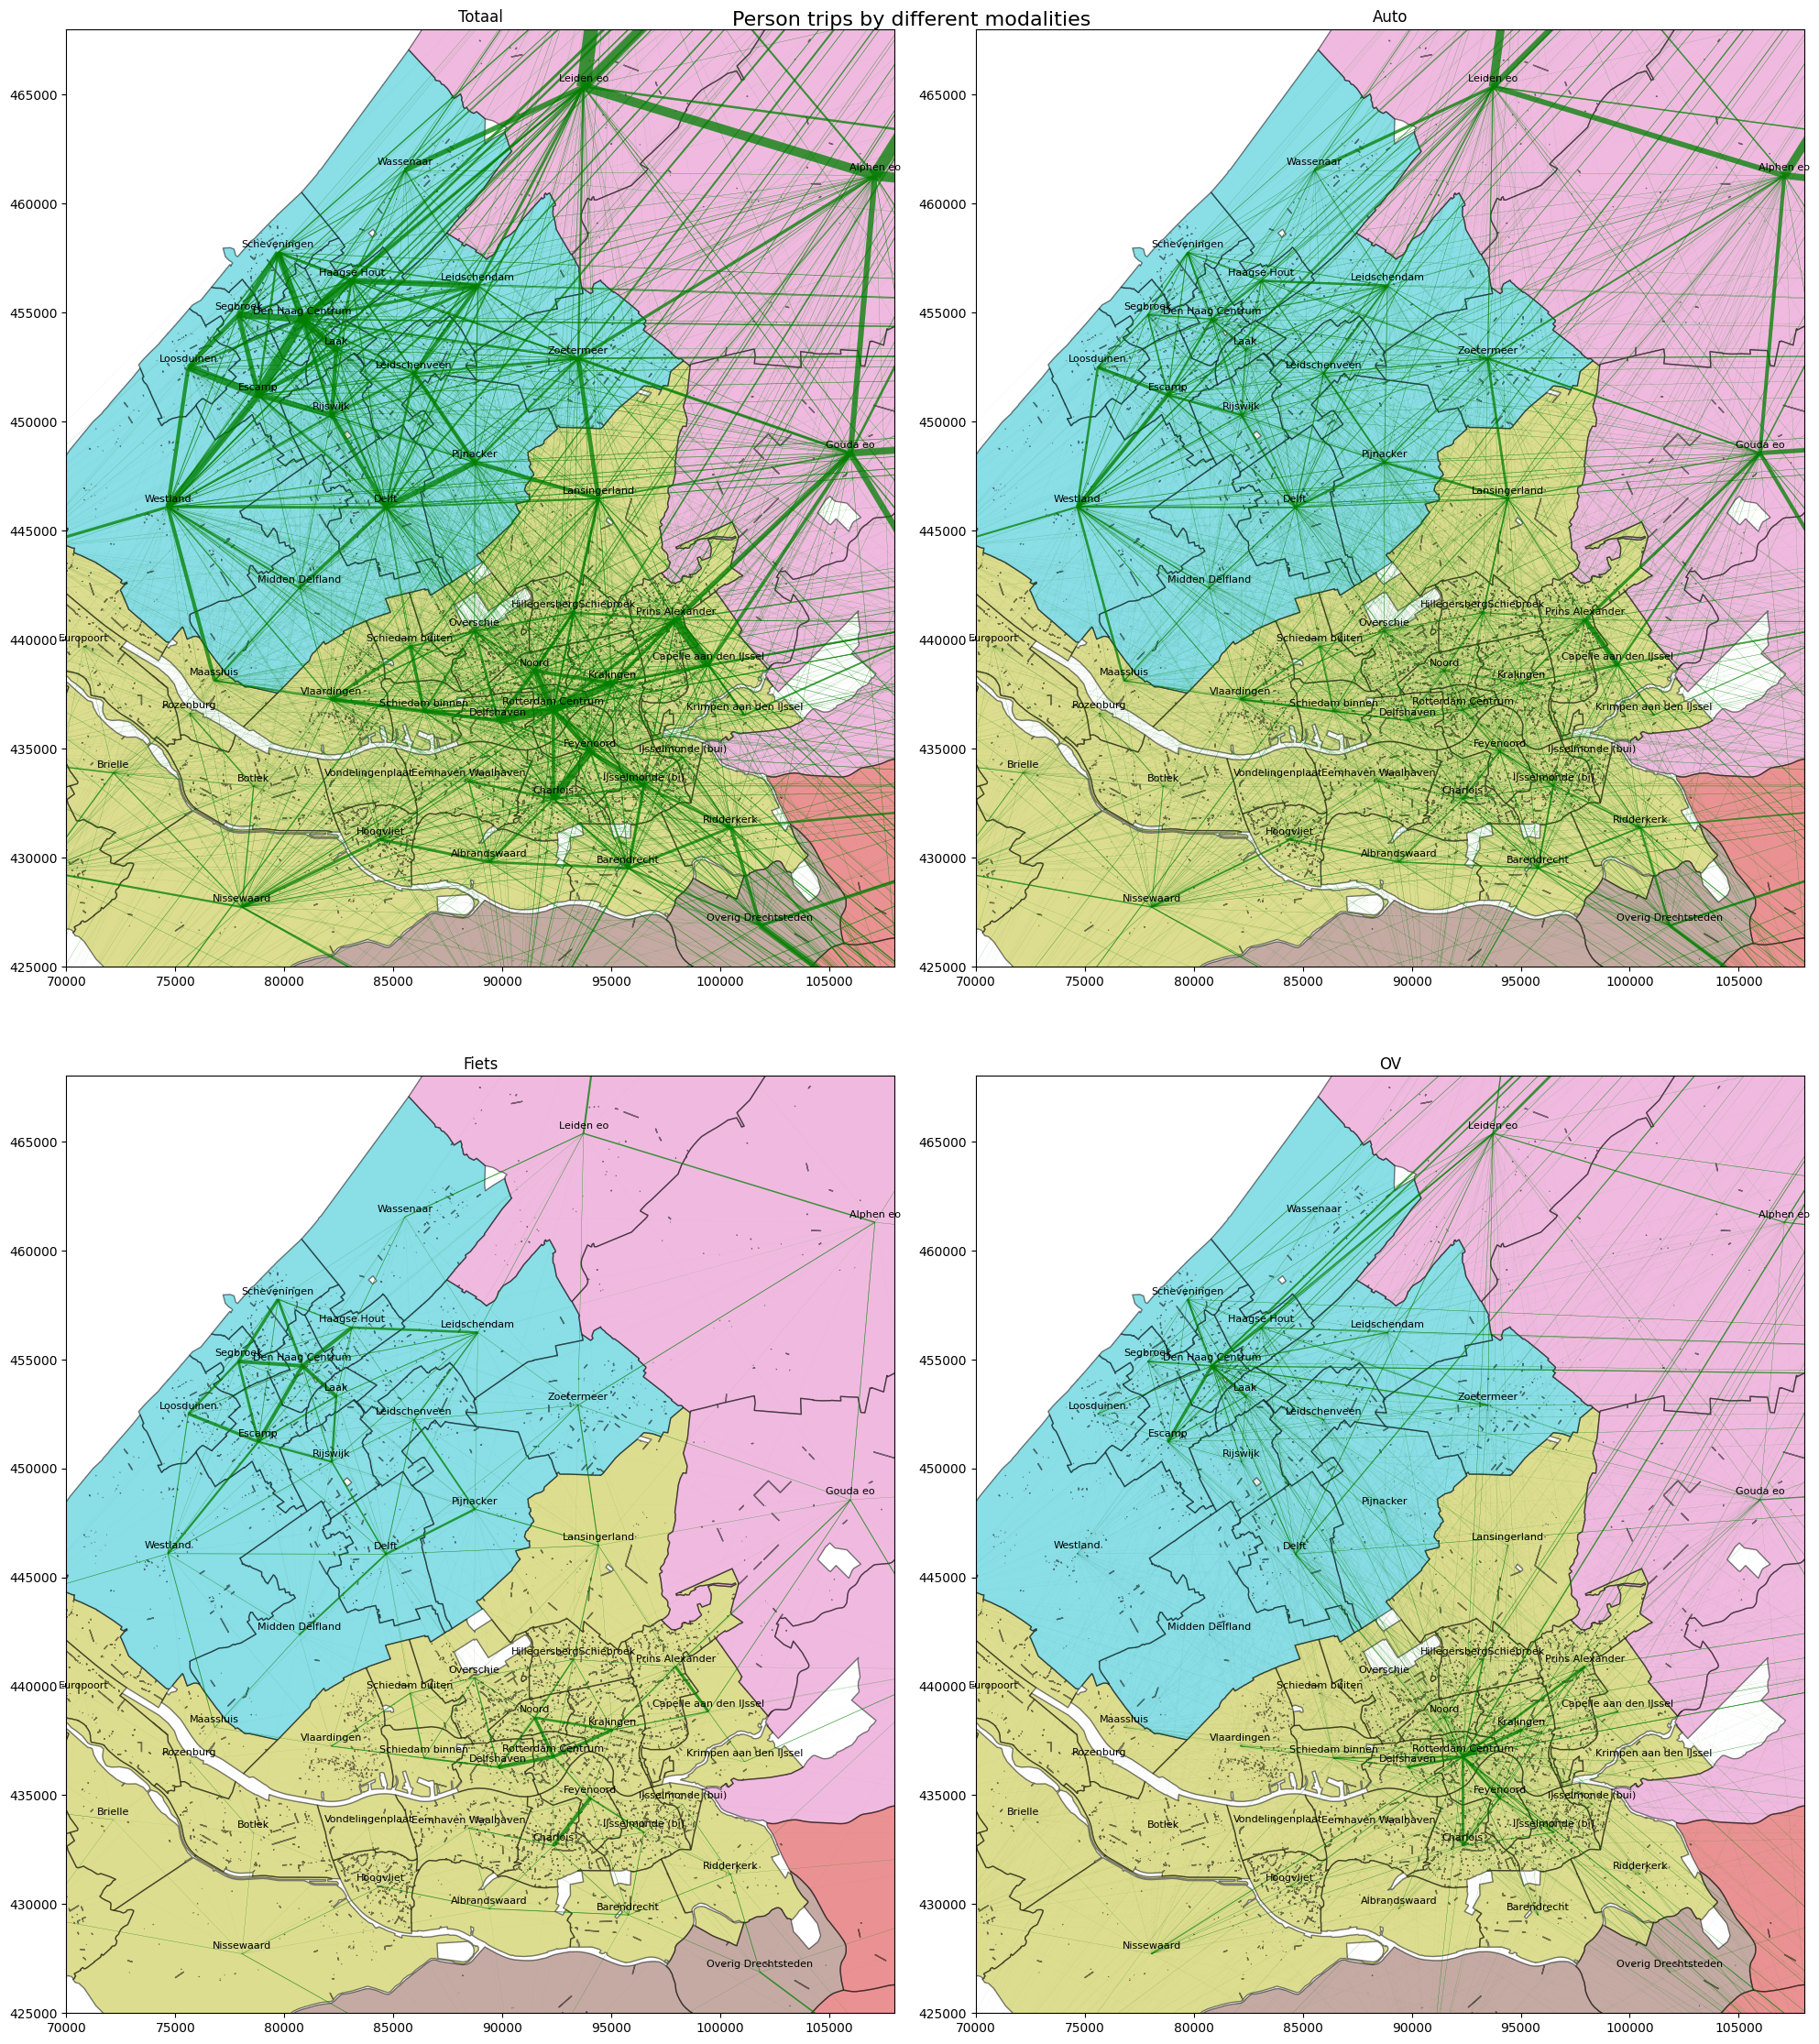

In [130]:
mod = "Totaal"

def plot_od_demand(mod, ax):
    odc = od[mod]
    # Create a GeoDataFrame to hold the lines
    lines_data = []
    
    # Iterate through the OD-matrix and create lines
    for origin in odc.index:
        for destination in odc.columns:
            if origin != destination and odc.at[origin, destination] > 0:
                origin_geom = areas_65.loc[origin].geometry.centroid
                destination_geom = areas_65.loc[destination].geometry.centroid
                line = LineString([origin_geom, destination_geom])
                lines_data.append({
                    'origin': origin,
                    'destination': destination,
                    'volume': odc.at[origin, destination],
                    'geometry': line
                })
    
    # Create a GeoDataFrame from the lines data
    lines = gpd.GeoDataFrame(lines_data, geometry='geometry', crs=areas_65.crs)
    
    # Plot the areas and the OD lines
    areas_65.plot(ax=ax, column='GEBIEDEN', edgecolor='black', alpha=0.5)
    lines.plot(ax=ax, color='green', linewidth=lines['volume'] / 5000, alpha=0.5, legend=True)
    # Set x and y limits
    ax.set_xlim(70000, 108000)
    ax.set_ylim(425000, 468000)
    
    # Add labels to areas
    for idx, row in areas_65.iterrows():
        ax.annotate(text=row['65x65 Naam'], xy=(row.geometry.centroid.x, row.geometry.centroid.y + 250), color='black', fontsize=8, ha='center')
    # Set subplot title
    ax.set_title(mod)

fig, ax = plt.subplots(2, 2, figsize=(20, 23))
for i, mod in enumerate(["Totaal", "Auto", "Fiets", "OV"]):
    plot_od_demand(mod, ax[i // 2, i % 2])

plt.tight_layout()
plt.suptitle("Person trips by different modalities", fontsize=16)
plt.savefig(f"od_demand.png", dpi=300, bbox_inches='tight')
plt.show()